<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/Gratuitously_complex_adding_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The most complex adding machine ever! (my first independent DL project)
The purpose of my model is to predict the outcome of adding two numbers between -100 and 100.

At first glance, the idea might sound unconventional, but my vision for the project is to enable my model to KNOW the answers, rather than calculate them. It's similar to how we solve 8+8. We don't actually calculate it; we just... know it! :)

What's interesting is that the model seems to be getting quite good at computing numbers outside the <-100, 100> range.

The conclusion of the project is that the model only needs to learn ONE weight in one unit, specifically '1'. Since the problem is very linear, there could be just one node (Linear(2,1)) with a weight of 1, but who doesn't like to experiment :)

## Imports

In [17]:
# imports

# learning and logistics
import torch
import torch.nn as nn
import torch.nn.functional as F

# managing data
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Creating and processing data

In [9]:
# creating N number of 2 digit pairs (data) and their sum (labels)
def create_data(N: int):
    data = torch.randint(-1000, 1001, size=(N, 2))
    labels = torch.sum(data, axis=1, keepdim=True)
    return data, labels

In [10]:
# INPUT NUMBER OF DATA TO GENERATE
data, labels = create_data(10000)
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long()

# dividing data into 90/10 sets (train, dev, test)
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size=0.9)

# converting data into TensorDatasets and then DataLoaders
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=16,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

<ipython-input-10-1872cf3b36b3>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT = torch.tensor(data).float()
<ipython-input-10-1872cf3b36b3>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor(labels).long()


## Creating Deep Learning model

In [11]:
# function to create model, loss function and optimizer
def create_model():

    class AddingNet(nn.Module):

        # class initialisation
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(2,4)

            # output layer
            self.output = nn.Linear(4, 1)

        # forward pass
        def forward(self, x):

            x = F.relu( self.input(x) )

            return self.output(x)

    # model instance
    net = AddingNet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

## Trainining function

In [12]:
def training_loop():

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfun, optimizer = create_model()


    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y.float())

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            batchAcc.append( 100*torch.mean( (torch.abs(yHat-y)<1).float() ) )

        # average accuracy and losses over batches
        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean( (torch.abs(yHat-y)<1).float() ) )

    return trainAcc, testAcc, losses, net

## Run the model

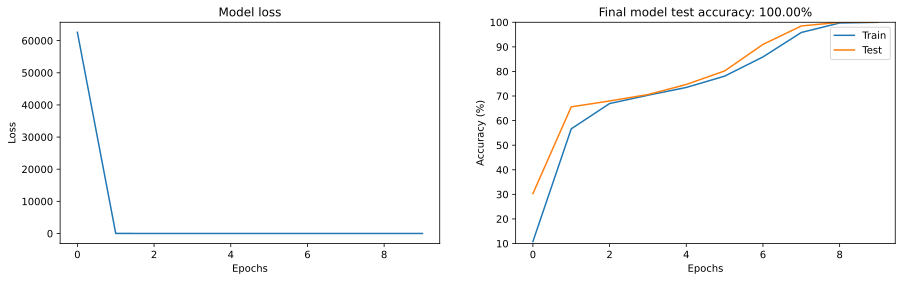

In [21]:
# running the model once as a test
trainAcc, testAcc, losses, net = training_loop()

fig,ax = plt.subplots(1,2,figsize=(15,4))

# plotting losses
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

# plotting accuracy
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [14]:
# run the model 10 times to check reproducibility

for i in range(10):

  # create a new 'machine' and train it
  trainAcc, testAcc, losses, net = training_loop()

  # report accuracy
  print('Model instance %s, final TRAIN/TEST accuracies: %g%%, %g%%' %(i+1,trainAcc[-1],testAcc[-1]))

Model instance 1, final TRAIN/TEST accuracies: 99.7665%, 99.9%
Model instance 2, final TRAIN/TEST accuracies: 99.9555%, 100%
Model instance 3, final TRAIN/TEST accuracies: 100%, 100%
Model instance 4, final TRAIN/TEST accuracies: 99.8443%, 100%
Model instance 5, final TRAIN/TEST accuracies: 99.9889%, 100%
Model instance 6, final TRAIN/TEST accuracies: 100%, 100%
Model instance 7, final TRAIN/TEST accuracies: 99.7776%, 100%
Model instance 8, final TRAIN/TEST accuracies: 100%, 100%
Model instance 9, final TRAIN/TEST accuracies: 100%, 100%
Model instance 10, final TRAIN/TEST accuracies: 100%, 100%


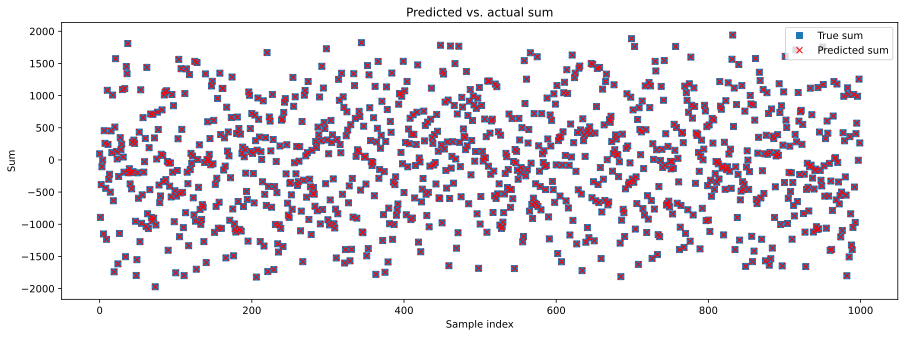

In [15]:
# some plots from the final model

data = torch.randint(low=-1000,high=1001,size=(1000,2)).float()
labels = torch.sum(data,axis=1,keepdim=True)

# evaluate the model and compute accuracy
with torch.no_grad():
  predictions = net(data)


# true and predicted values
fig = plt.figure(figsize=(15,5))
plt.plot(labels,'s')
plt.plot(np.round(predictions.detach()),'rx')
plt.legend(['True sum','Predicted sum'])
plt.xlabel('Sample index')
plt.ylabel('Sum')
plt.title('Predicted vs. actual sum')
plt.show()

# Little manual experiment for fun
I played with some numbers manually and it turns out that the model can guess even higher numbers with accuracy of +/- 1

In [19]:
# two inputs for the sum
x = 1325
y = -1200

# obtaining prediction from the last trained model
with torch.no_grad():
  predictions = net(torch.Tensor([x, y]))
print(f'Result of {x} + {y} = {int(predictions[0])}')

Result of 1325 + -1200 = 125
